In [1]:
pip install tensorflow

  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached wrapt-1.14.1-cp311-cp311-win_amd64.whl.metadata (6.9 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)
   ---------------------------------------- 0.0/133.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/133.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/133.7 kB ? eta -:--:--
   --- ------------------------------------ 10.2/133.7 kB ? eta -:--:--
   --- ------------------------------------ 10.2/133.7 kB ? eta -:--:--
   --- ------------------------------------ 10.2/133

## Імпортування бібліотек

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [3]:
df = pd.read_csv("UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
gun_shot_files = df[df['class'] == 'gun_shot']['slice_file_name']
df = df.drop(gun_shot_files.index)
df['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64

## Опрацювання звуків, створення спектограм

In [4]:
# mean_length = int(np.mean([len(librosa.load(os.path.join(os.path.abspath('sounds'), str(row["slice_file_name"])))[0]) for _, row in df.iterrows()]))
# print(mean_length)

In [5]:
mean_length = 81479

In [6]:
data = []
labels = []

batch_size = 10  # Adjust this based on your system's memory capacity

# Iterate over the DataFrame in batches
for start_index in tqdm(range(0, len(df), batch_size)):
    batch_data = []
    batch_labels = []
    for index, row in df.iloc[start_index:start_index+batch_size].iterrows():
        file_name = os.path.join(os.path.abspath('sounds'), str(row["slice_file_name"]))
        audio, sample_rate = librosa.load(file_name, sr=44100, mono=True)

        # Resize the audio to the mean length
        if len(audio) < mean_length:
            # Pad with zeros
            pad_start = (mean_length - len(audio)) // 2
            pad_end = mean_length - len(audio) - pad_start
            audio = np.pad(audio, (pad_start, pad_end), mode='constant')
        elif len(audio) > mean_length:
            # Trim excess
            audio = audio[:mean_length]

        # Convert audio to spectrogram
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        
        # Convert to decibels
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Add to batch_data list
        batch_data.append(spectrogram_db)

        # Extract label and add to batch_labels list
        label = row["class"]
        batch_labels.append(label)

    # Convert batch_data and batch_labels to numpy arrays and append to data and labels lists
    data.append(np.array(batch_data))
    labels.append(batch_labels)

# Concatenate the batches into single numpy arrays
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

100%|██████████| 836/836 [02:52<00:00,  4.85it/s]


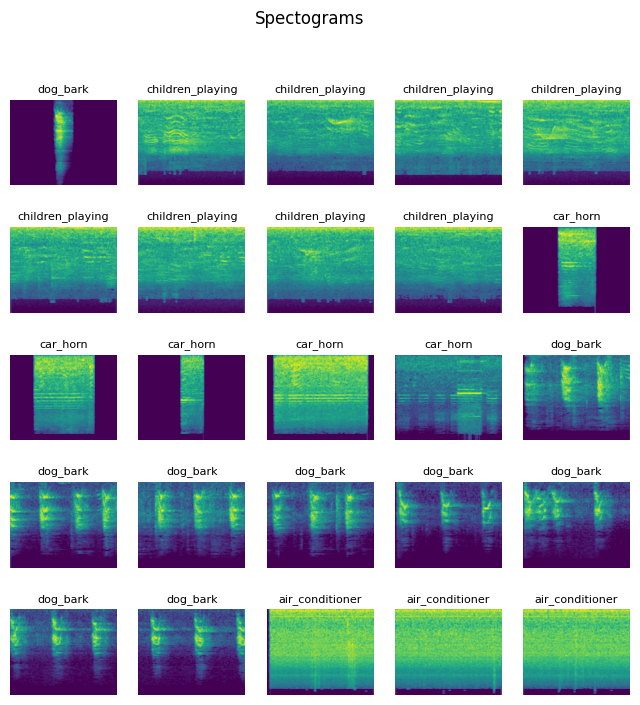

In [6]:
# plt.imshow(data[0])
# plt.axis('off')
# plt.show()

def display_images(images, title):
    plt.figure(figsize=(8, 8))
    plt.suptitle(title)

    for i in range(images.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title("{}".format(labels[i]), fontsize=8)
        plt.axis('off')
    plt.show()

# Display original and noisy images
display_images(data[:25], title='Spectograms')

## Поділ даних

In [7]:
le = LabelEncoder().fit(df["class"])
class_labels = le.classes_.astype(str)
classes = le.transform(df["class"])

X_train, X_temp, y_train, y_temp = train_test_split(data, classes, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Навчальні дані:", X_train.shape, y_train.shape)
print("Валідаційні дані:", X_val.shape, y_val.shape)
print("Тестові дані:", X_test.shape, y_test.shape)

Навчальні дані: (6686, 128, 160) (6686,)
Валідаційні дані: (836, 128, 160) (836,)
Тестові дані: (836, 128, 160) (836,)


In [7]:
print(y_train)

[8 0 5 ... 6 3 8]


## Створення нейромережі і тренування

In [8]:
def training_graph(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

In [9]:
def build_compile_model():
    model = models.Sequential([
    layers.Conv2D(8, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(128, 160, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(9, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [10]:
# Set random seed for TensorFlow
tf.keras.utils.set_random_seed(40)

# Set random seed for TensorFlow
tf.random.set_seed(42)

model = build_compile_model()

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.0001)
# Train the model
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), callbacks=[reduce_lr])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)




Epoch 1/40


209/209 [==============================] - 23s 67ms/step - loss: 1.5367 - accuracy: 0.4387 - val_loss: 1.3307 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 2/40
209/209 [==============================] - 15s 71ms/step - loss: 0.9961 - accuracy: 0.6642 - val_loss: 0.8861 - val_accuracy: 0.6998 - lr: 0.0010
Epoch 3/40
209/209 [==============================] - 15s 71ms/step - loss: 0.7564 - accuracy: 0.7559 - val_loss: 0.8184 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 4/40
209/209 [==============================] - 15s 71ms/step - loss: 0.6335 - accuracy: 0.7885 - val_loss: 0.9551 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 5/40
209/209 [==============================] - 16s 78ms/step - loss: 0.5205 - accuracy: 0.8290 - val_loss: 0.5981 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 6/40
209/209 [==============================] - 21s 100ms/step - loss: 0.4557 - accuracy: 0.8501 - val_loss: 1.6319 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 7/40
209/209 [==============================] 

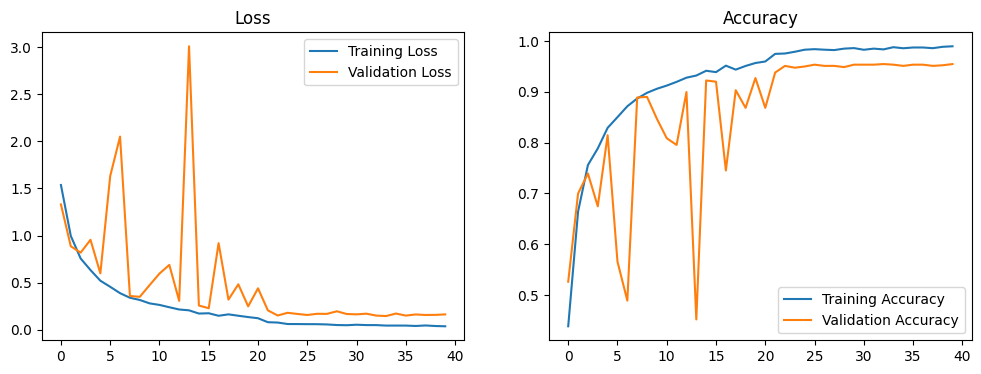

In [44]:
training_graph(history)

In [28]:
model = build_compile_model()

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/1000
105/105 [==============================] - 22s 154ms/step - loss: 1.2012 - accuracy: 0.5866 - val_loss: 1.5547 - val_accuracy: 0.5239
Epoch 2/1000
105/105 [==============================] - 23s 221ms/step - loss: 0.6761 - accuracy: 0.7824 - val_loss: 0.9836 - val_accuracy: 0.6722
Epoch 3/1000
105/105 [==============================] - 16s 150ms/step - loss: 0.4279 - accuracy: 0.8678 - val_loss: 1.7380 - val_accuracy: 0.5072
Epoch 4/1000
105/105 [==============================] - 16s 152ms/step - loss: 0.3077 - accuracy: 0.9055 - val_loss: 0.7313 - val_accuracy: 0.7763
Epoch 5/1000
105/105 [==============================] - 12s 119ms/step - loss: 0.2144 - accuracy: 0.9361 - val_loss: 0.8177 - val_accuracy: 0.7416
Epoch 6/1000
105/105 [==============================] - 11s 104ms/step - loss: 0.1551 - accuracy: 0.9566 - val_loss: 0.3979 - val_accuracy: 0.8888
Epoch 7/1000
105/105 [==============================] - 10s 99ms/step - loss: 0.1118 - accuracy: 0.9719 - val_loss: 0.

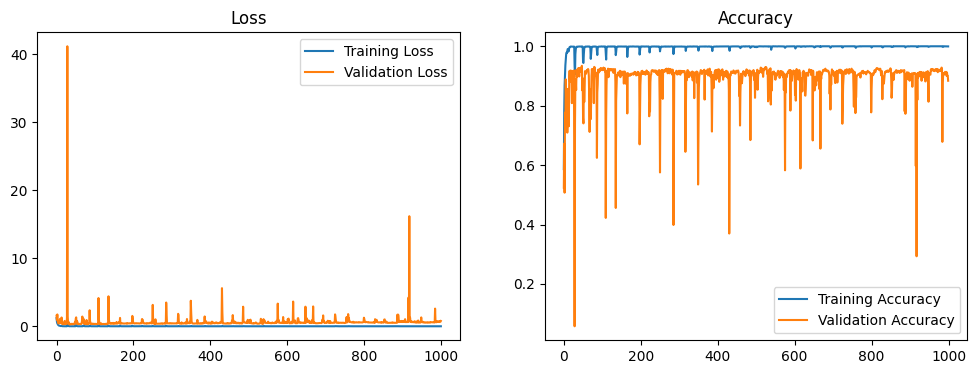

In [29]:
training_graph(history)

## Тестування моделі

In [11]:
from sklearn.metrics import f1_score
# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1 score:', f1)

27/27 [==============================] - 1s 14ms/step
F1 score: 0.9446310743723294


In [46]:
in_top_three = 0

for prediction_n, prediction in enumerate(y_pred):
    # Get the top k predicted classes and their probabilities
    top_k_classes = np.argsort(prediction)[::-1][:3]
    top_k_probabilities = prediction[top_k_classes]

    if np.isin(y_test[prediction_n], top_k_classes):
        in_top_three += 1

    print("Top k classes:", top_k_classes)
    print("Top k probabilities:", top_k_probabilities)
    print("True label:", y_test[prediction_n])
    print("------------------------------------------------------------------------------------------------")

print("Percentage of right predictions in top 3:", in_top_three / len(y_pred) * 100)

Top k classes: [2 3 5]
Top k probabilities: [0.5048364  0.19593556 0.17698184]
True label: 5
------------------------------------------------------------------------------------------------
Top k classes: [4 1 3]
Top k probabilities: [9.9994409e-01 4.7444166e-05 4.4244398e-06]
True label: 4
------------------------------------------------------------------------------------------------
Top k classes: [7 3 2]
Top k probabilities: [0.97631526 0.02229669 0.00136511]
True label: 7
------------------------------------------------------------------------------------------------
Top k classes: [5 1 8]
Top k probabilities: [9.9984872e-01 1.1642809e-04 2.8605220e-05]
True label: 5
------------------------------------------------------------------------------------------------
Top k classes: [0 2 4]
Top k probabilities: [0.9863528  0.0075036  0.00226767]
True label: 0
------------------------------------------------------------------------------------------------
Top k classes: [7 3 5]
Top k pro

Fold 1/5
Validation accuracy for fold 1: 0.8468899726867676


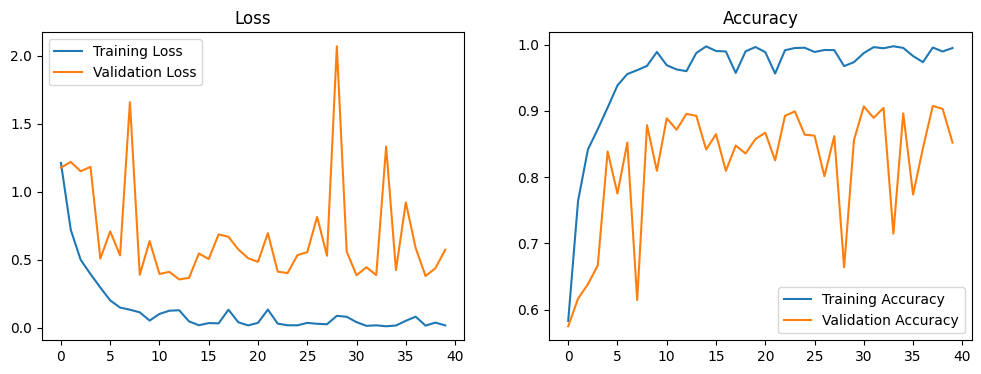

Fold 2/5
Validation accuracy for fold 2: 0.9078947305679321


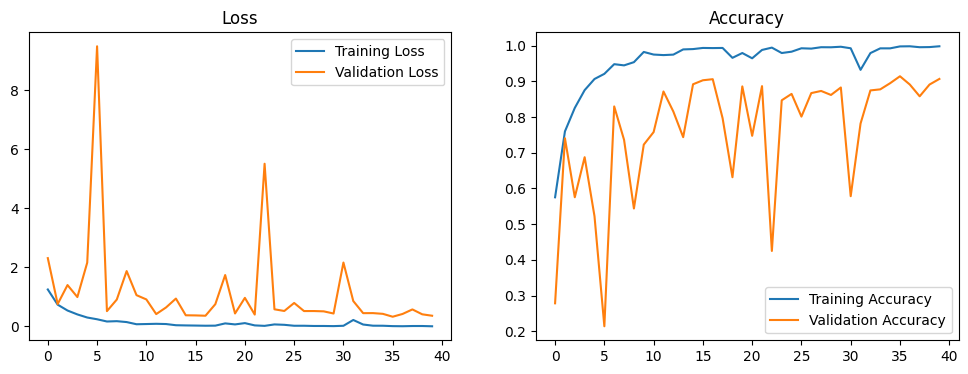

Fold 3/5
Validation accuracy for fold 3: 0.8911483287811279


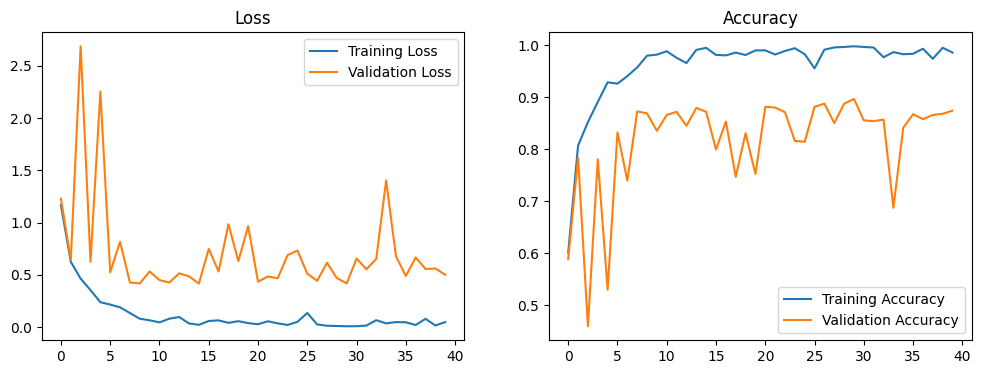

Fold 4/5
Validation accuracy for fold 4: 0.9066985845565796


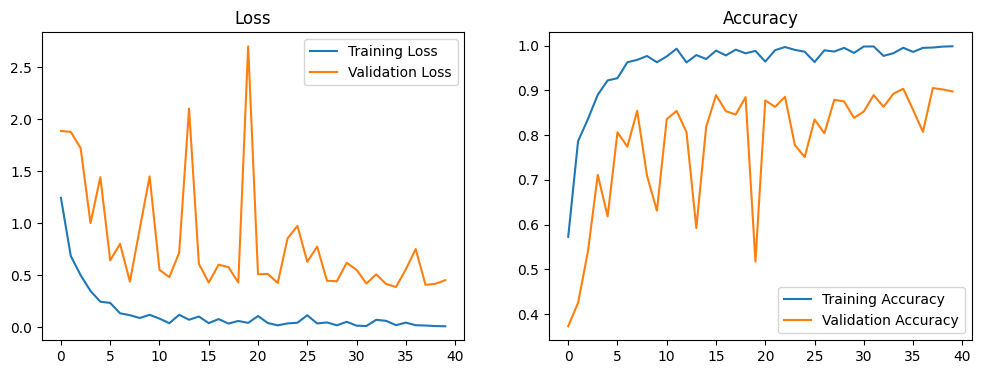

Fold 5/5
Validation accuracy for fold 5: 0.7655502557754517


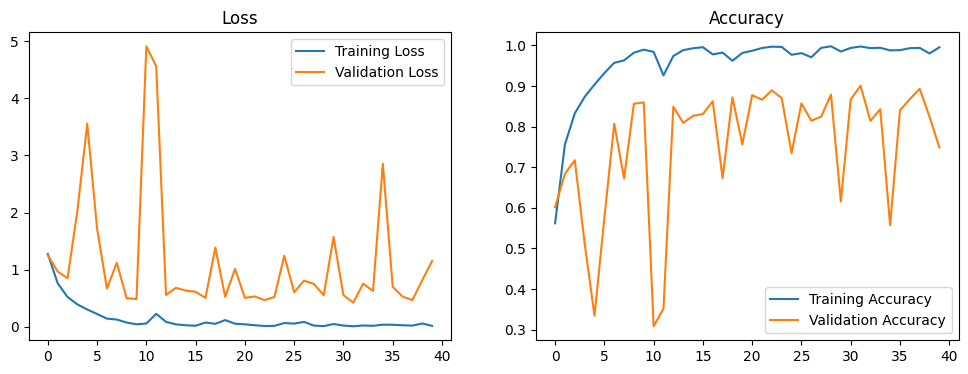

Mean test accuracy: 0.8636363744735718
Standard deviation of test accuracy: 0.05379849868778152


In [26]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold cross-validation
k = 5  # You can adjust this value based on your preference

# Initialize K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results
test_accuracies = []

# Iterate over the K-Fold splits
for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{k}")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    model = build_compile_model()

    # Train the model on the current fold
    history = model.fit(X_train_fold, y_train_fold, epochs=40, validation_data=(X_val_fold, y_val_fold), verbose=0)
    
    # Evaluate the model on the test fold
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'Validation accuracy for fold {fold + 1}: {test_acc}')
    training_graph(history)
    test_accuracies.append(test_acc)

# Compute the mean and standard deviation of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Mean test accuracy: {mean_test_accuracy}")
print(f"Standard deviation of test accuracy: {std_test_accuracy}")

## Збереження моделі

In [17]:
model.save('neural_network_model.h5')

c:\Users\ivann\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model.save_weights('neural_network_model_weights.h5')